In [1]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# seaborn settings, research paper style, and palette
sns.set_context("paper")
sns.set_palette("husl")

In [3]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

def get_latest_event_file(event_dir):
    event_files = os.listdir(event_dir)
    event_files.sort(key=lambda f: os.path.getmtime(os.path.join(event_dir, f)))
    return event_files[-1]

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "smth_value": [], "step": []})
    try:
        event_acc = EventAccumulator(path + "/" + get_latest_event_file(path))
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            smoothed_values = smooth(values, 0.5)
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "smth_value": smoothed_values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [5]:
experiments = [
    "ext1_tsa_all_sequential_constant",
    "ext1_tsa_all_sequential_linear",
    "ext1_tsa_all_sequential_log",
    "ext1_tsa_all_sequential_exp",
]

data_holders = []
for exp in experiments:
    path = f"runs/{exp}"
    data = tflog2pandas(path)
    data["exp"] = exp
    data_holders.append(data)

df = pd.concat(data_holders)

In [7]:
experiments = [
    "ext1_tsa_all_simul_constant",
    "ext1_tsa_all_simul_linear",
    "ext1_tsa_all_simul_log",
    "ext1_tsa_all_simul_exp",
]

data_holders = []
for exp in experiments:
    path = f"runs/{exp}"
    data = tflog2pandas(path)
    data["exp"] = exp
    data_holders.append(data)

df_simul = pd.concat(data_holders)

In [8]:
def get_plot(df, metric, title="", xlabel="Epoch", ylabel="Pooled Accuracy"):
    _t = df[df['metric'] == metric]
    _t.loc[:, 'Legend'] = _t['exp'].map(lambda x: x.split("_")[-1]).map({
        "constant": "No TSA",
        "linear": "Linear TSA",
        "log": "Log TSA",
        "exp": "Exp TSA",
    })
    fig = plt.figure(figsize=(4, 3))
    sns.lineplot(data=_t, x="step", y="smth_value", hue="Legend")

    # scale the x axis in half
    current_xlim = plt.xlim()  # Get the current x-axis limits
    new_xlim = (current_xlim[0], current_xlim[1] / 2)  # Calculate the new x-axis limits
    plt.xlim(new_xlim)  # Set the new x-axis limits
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    return fig

/tmp/ipykernel_2162579/3829961457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _t.loc[:, 'Legend'] = _t['exp'].map(lambda x: x.split("_")[-1]).map({


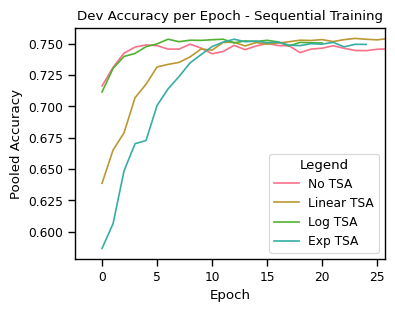

In [9]:
fig1 = get_plot(df, '_DevEval/pooled_score', "Dev Accuracy per Epoch - Sequential Training")
fig1.savefig("../milestone_latex/pics/tsa-sequential-dev.png", bbox_inches='tight', dpi=300)

/tmp/ipykernel_2162579/3829961457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _t.loc[:, 'Legend'] = _t['exp'].map(lambda x: x.split("_")[-1]).map({


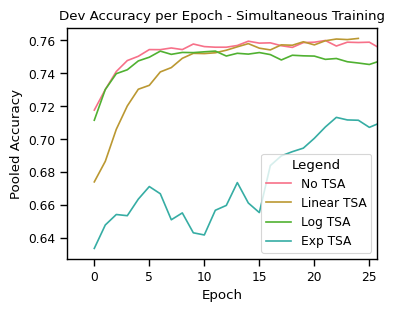

In [10]:
fig2 = get_plot(df_simul, '_DevEval/pooled_score', "Dev Accuracy per Epoch - Simultaneous Training")
fig2.savefig("../milestone_latex/pics/tsa-simul-dev.png", bbox_inches='tight', dpi=300)

/tmp/ipykernel_2162579/3829961457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _t.loc[:, 'Legend'] = _t['exp'].map(lambda x: x.split("_")[-1]).map({


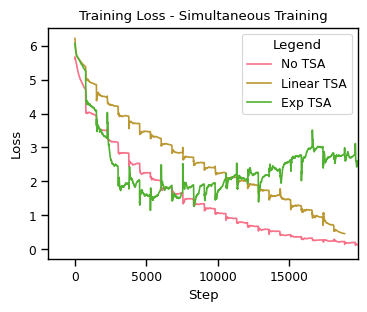

In [11]:
fig3 = get_plot(df_simul, 'Loss/combined-train', 
                "Training Loss - Simultaneous Training",
                ylabel="Loss", xlabel="Step")
fig3.savefig("../milestone_latex/pics/tsa-simul-loss.png", bbox_inches='tight', dpi=300)

/tmp/ipykernel_2162579/3829961457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _t.loc[:, 'Legend'] = _t['exp'].map(lambda x: x.split("_")[-1]).map({


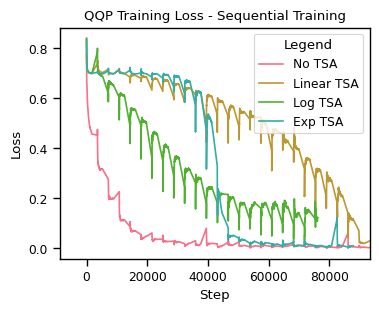

In [12]:
fig4 = get_plot(df, 'Loss/para-train', 
                "QQP Training Loss - Sequential Training",
                ylabel="Loss", xlabel="Step")
fig4.savefig("../milestone_latex/pics/tsa-seq-qqp-loss.png", bbox_inches='tight', dpi=300)

/tmp/ipykernel_2162579/3829961457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _t.loc[:, 'Legend'] = _t['exp'].map(lambda x: x.split("_")[-1]).map({


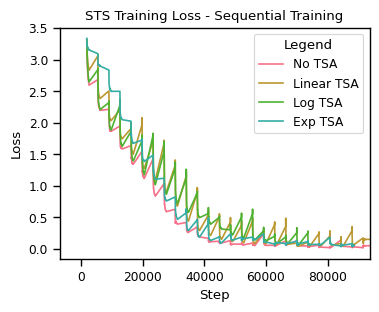

In [13]:
fig4 = get_plot(df, 'Loss/sts-train', 
                "STS Training Loss - Sequential Training",
                ylabel="Loss", xlabel="Step")
fig4.savefig("../milestone_latex/pics/tsa-seq-sts-loss.png", bbox_inches='tight', dpi=300)

/tmp/ipykernel_2162579/3829961457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _t.loc[:, 'Legend'] = _t['exp'].map(lambda x: x.split("_")[-1]).map({


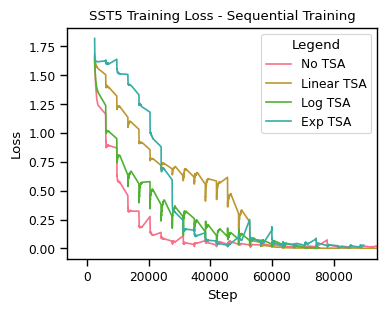

In [14]:
fig4 = get_plot(df, 'Loss/sst-train', 
                "SST5 Training Loss - Sequential Training",
                ylabel="Loss", xlabel="Step")
fig4.savefig("../milestone_latex/pics/tsa-seq-sst-loss.png", bbox_inches='tight', dpi=300)

# Get model performance

In [52]:
import glob

In [100]:
experiments = glob.glob("runs/new_ext1*")

In [106]:
res_holder = []
for exp_nm in experiments:
    path = f"{exp_nm}"
    df = tflog2pandas(path)
    tmp = pd.pivot_table(index='step', columns='metric', values='value', data=df)
    tmp = tmp[~tmp['_DevEval/pooled_score'].isna()].reset_index()
    res = tmp.iloc[tmp['_DevEval/pooled_score'].argmax(), :].to_dict()
    # res = tmp.iloc[tmp['step'].argmax(), :].to_dict()
    res['exp_nm'] = exp_nm
    res_holder.append(res)

In [107]:
col_order = ['exp_nm', '_DevEval/sst_accuracy', '_DevEval/para_accuracy', '_DevEval/sts_corr', '_DevEval/pooled_score']

In [108]:
report_df = pd.DataFrame(res_holder)[col_order]

In [109]:
report_df

,exp_nm,_DevEval/sst_accuracy,_DevEval/para_accuracy,_DevEval/sts_corr,_DevEval/pooled_score
0,runs/new_ext1_tsa_all_sequential_exp,0.519528,0.829281,0.858662,0.759380
1,runs/new_ext1_tsa_all_simul_linear,0.525886,0.830419,0.856693,0.761550
2,runs/new_ext1_tsa_all_simul_log,0.510445,0.837493,0.856795,0.758778
3,runs/new_ext1_tsa_all_simul_constant,0.515895,0.829330,0.855865,0.757719
4,runs/new_ext1_tsa_all_simul_exp,0.510445,0.833783,0.865162,0.758936
5,runs/new_ext1_tsa_all_sequential_linear,0.522253,0.822924,0.848777,0.756522
6,runs/new_ext1_tsa_all_sequential_constant,0.520436,0.817433,0.856791,0.755421
7,runs/new_ext1_tsa_all_sequential_log,0.510445,0.814885,0.857698,0.751393


In [110]:
report_df.to_clipboard()